In this notebook we will reproduce the work published in the paper ["FEP Augmentation as a Means to Solve Data Paucity Problems for Machine Learning in Chemical Biology"](https://pubs.acs.org/doi/10.1021/acs.jcim.4c00071).  In this paper the authors used FEP data to augment a dataset and generate a predictive model for cSrc activity.  They compare three predictive models.  
* A model generated from 11 starting molecules
* A model generated from 11 starting molecules augmented by 84 experimental datapoints
* A model generated from 11 starting molecules augmented by 84 FEP datapoints 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import useful_rdkit_utils as uru
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from tqdm.auto import tqdm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#### 1. Data Preprocessing
Read the input data

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/refs/heads/main/papers/ML_FEP/cSrc_dataset.csv")

Add an index column to the dataframe and convert the IC50 values to pIC50 values. 

In [98]:
df["idx"] = range(0,len(df))
df["pIC50"] = -np.log10(df["Src-IC50"]*1e-9)
df["pIC50_FEP"] = -np.log10(df["IC50_b_theor(nM)"]*1e-9)                            

Use the [useful_rdkit_utils](https://pubs.acs.org/doi/10.1021/acs.jcim.4c00071) package to add fingerprint column to the dataframe. 

In [99]:
smi2fp = uru.Smi2Fp()
df["fp"] = df.Smiles.apply(smi2fp.get_np)

Plot the distribution of experimental pIC50 values. 

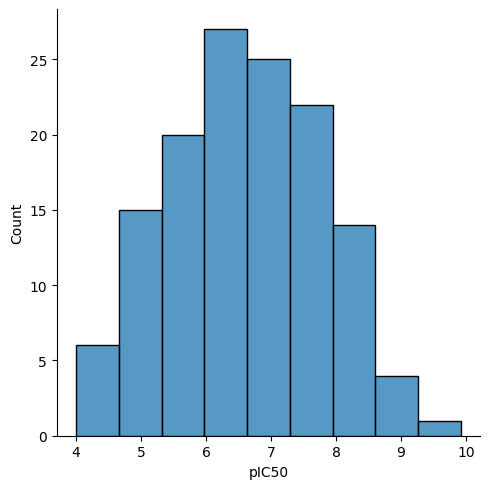

In [100]:
sns.displot(df.pIC50)

Replace spaces in the column names with underscores, this makes it easier to use the column names in Pandas. 

In [101]:
df.columns = [x.replace(" ","_") for x in df.columns]

Label the reference columns

In [102]:
df['is_ref'] = [x in ['PP56', 'PP494', 'PP121', 'PP102'] for x in df.Compound_Key]

In [103]:
pIC50_cutoff = -np.log10(50e-9)

Label the active compounds

In [104]:
df['active'] = df.pIC50 > pIC50_cutoff
df['active_FEP'] = df.pIC50_FEP > pIC50_cutoff

A function to get the control set of molecules, this is the three molecules from the training set plus seven random molecules, five from scaffold 1 and one each from scaffolds 2 and 3. 

In [105]:
def get_control_set(df):    
    df_list = [df.query("is_ref")]
    sample_list = [[1,5],[2,1],[3,1]]
    for scaffold, count in sample_list:
        df_list.append(df.query("is_ref == False and Scaffold == @scaffold").sample(count))    
    return pd.concat(df_list)

#### 2. Build ML models
For each modeling strategy (controls, augmented with experimental data, augmented with FEP data) build 100 ML models.  Collect the AUC values along the way. 

In [106]:
auc_list = []
curve_list = []
for i in tqdm(range(0,100)):
    control_set = get_control_set(df)
    train, test = train_test_split(df.query("idx not in @control_set.idx"),train_size=0.6)
    train = pd.concat([control_set, train])
    # Controls
    rf_control = RandomForestClassifier()
    rf_control.fit(np.stack(control_set.fp),control_set.active)
    pred_control = rf_control.predict_proba(np.stack(test.fp))
    auc_control = roc_auc_score(test.active,pred_control[:,1])
    auc_list.append([auc_control,"control"])
    curve_list.append([roc_curve(test.active,pred_control[:,1]),"control"])
    # Augmented with experimental data
    rf_exp_aug = RandomForestClassifier()
    rf_exp_aug.fit(np.stack(train.fp),train.active)
    pred_exp_aug = rf_exp_aug.predict_proba(np.stack(test.fp))
    auc_exp_aug = roc_auc_score(test.active,pred_exp_aug[:,1])
    auc_list.append([auc_exp_aug,"exp_aug"])
    curve_list.append([roc_curve(test.active,pred_exp_aug[:,1]),"exp_aug"])
    # Augmented with FEP data
    rf_fep_aug = RandomForestClassifier()
    rf_fep_aug.fit(np.stack(train.fp),train.active_FEP)
    pred_fep_aug = rf_fep_aug.predict_proba(np.stack(test.fp))
    auc_fep_aug = roc_auc_score(test.active,pred_fep_aug[:,1])
    auc_list.append([auc_fep_aug,"fep_aug"])  
    curve_list.append([roc_curve(test.active,pred_fep_aug[:,1]),"fep_aug"])

  0%|          | 0/100 [00:00<?, ?it/s]

#### 3. Analysis
Let's reproduce **Figure 7** in the paper, where the authors plot average AUC curves for the three methods. I think we miss some information using this approach, but I want to convince myself I can reproduce the analysis.   
First, we'll extract the False Positive Rate (FPR) and True Positive Rate (TPR) curves from the dataframe. 

In [107]:
curve_df = pd.DataFrame(curve_list,columns=["curve","method"])
curve_df['fpr'] = [x[0] for x in curve_df.curve]
curve_df['tpr'] = [x[1] for x in curve_df.curve]

Next we'll write a function to interpolate and calcuate the average FPR and TPR curves. 

In [108]:
def get_auc_mean(df_in):
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    n_runs = len(df_in)
    for fpr,tpr in df_in[["fpr","tpr"]].values:
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        mean_tpr += interp_tpr
    mean_tpr /= n_runs
    return mean_fpr, mean_tpr

Now we loop over the three methods, extract average AUC curves and plot the curves. 

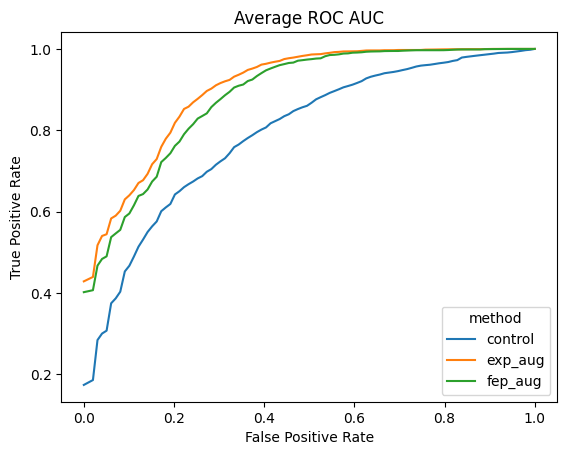

In [109]:
point_list = []
for method in curve_df.method.unique():
    tmp_df = curve_df.query("method == @method")
    a,b = get_auc_mean(tmp_df)
    for i,j in zip(a,b):
        point_list.append([i,j,method])
point_df = pd.DataFrame(point_list,columns=["fpr","tpr","method"])
ax = sns.lineplot(x="fpr",y="tpr",hue="method",data=point_df)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Average ROC AUC");

Create a dataframe with the AUC data

In [110]:
auc_df = pd.DataFrame(auc_list,columns=["AUC","method"])

I prefer to use boxplots for this comparison.  With the boxplots, we can see the AUC distributions over the 100 experiments. 

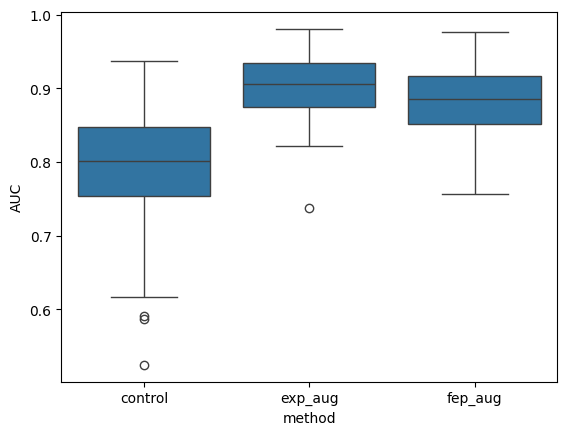

In [111]:
sns.boxplot(x="method",y="AUC",data=auc_df);

Use Tukey's Honestly Signficant Difference (HSD) Test to determine whether the AUC distributions are different. 

In [112]:
tukey_res = pairwise_tukeyhsd(endog=auc_df.AUC,groups=auc_df.method)
print(tukey_res)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
control exp_aug   0.1112    0.0  0.0913 0.1311   True
control fep_aug   0.0923    0.0  0.0724 0.1122   True
exp_aug fep_aug  -0.0189 0.0659 -0.0388  0.001  False
-----------------------------------------------------


Plot the means and confence intervals from the Tukey HSD test.  We use the experimental augentation as a reference.  While the AUC distribution for the FEP augmented models is similar, the confience intervals don't overlap. 

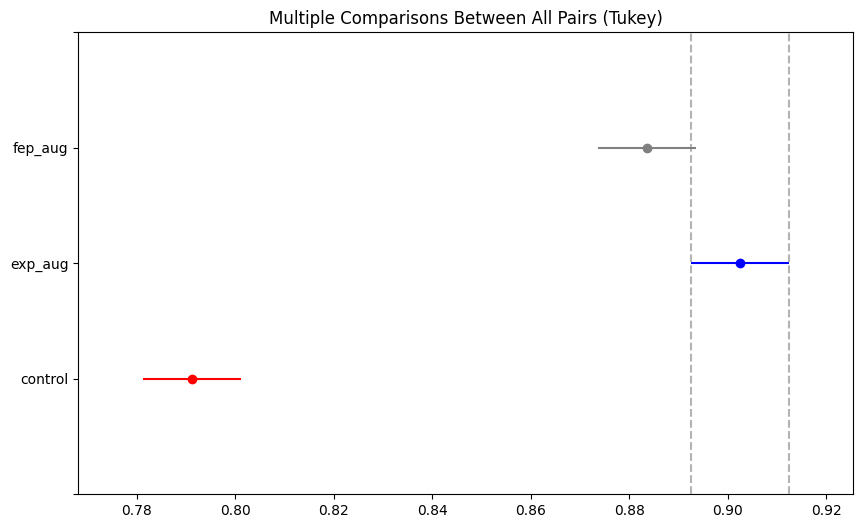

In [113]:
_ = tukey_res.plot_simultaneous(comparison_name="exp_aug")